In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pycaret.classification import * 

In [3]:
df = pd.read_csv('train2.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


(None, (8693, 14))

In [38]:
#seeing if the dataset is balanced
df['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [5]:
#missing values as percentages of the train dataset 

display(((df.isnull().sum() / df.shape[0])*100).to_frame().rename({0: 'Missing Values % (Train)'}, axis = 1).style.background_gradient('gist_heat_r'))

,Missing Values % (Train)
PassengerId,0.000000
HomePlanet,2.312205
CryoSleep,2.496261
Cabin,2.289198
Destination,2.093639
Age,2.059128
VIP,2.335212
RoomService,2.082135
FoodCourt,2.105142
ShoppingMall,2.392730


In [6]:
#seeing if there are any differences regarding home planet 

df.groupby('HomePlanet').mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
HomePlanet,,,,,,,
Earth,26.068232,136.940209,137.228857,133.872606,142.781701,138.132933,0.423946
Europa,34.419664,145.231981,1503.212950,151.132820,848.055609,875.765998,0.658846
Mars,29.297203,552.897272,54.361999,308.445734,110.221706,47.440698,0.523024


In [7]:
#clustering the services so the model can understand better the relations 

x_cluster = df.loc[:, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
x_cluster

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0
8689,0.0,0.0,0.0,0.0,0.0
8690,0.0,0.0,1872.0,1.0,0.0
8691,0.0,1049.0,0.0,353.0,3235.0


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(x_cluster)
x_cluster_new = imputer.transform(x_cluster)

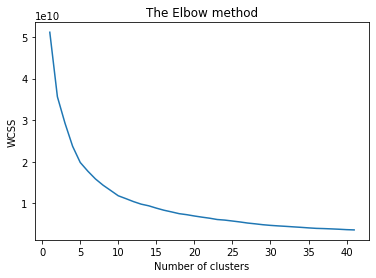

In [9]:
wcss = []
for i in range(1,42):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42) #usar o kmeans ++ ajuda na inicialização dos centroides, pois
    #ele não coloca em lugares muito aleatorios, o que pode gerar problemas
    kmeans.fit(x_cluster_new)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,42), wcss)
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [10]:
model_kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42)
df['Cluster']= model_kmeans.fit_predict(x_cluster_new)
df['Cluster'] = df['Cluster'].astype("category")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cluster
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0


In [11]:
df['Age'] = df['Age'].fillna(df.groupby('HomePlanet')['Age'].transform('median'))
#as passengers age are considerably different for each planet, let's group by home planet and the fill the NaN values wuth the median

In [12]:
df['CryoSleep'] = df['CryoSleep'].fillna(df.groupby('Cluster')['CryoSleep'].transform('mean'))

In [13]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep         0
Cabin           199
Destination     182
Age               2
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Cluster           0
dtype: int64

In [14]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cluster
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0


In [15]:
#selecting categorical columns
categorical_cols = [cname for cname in df.columns if df[cname].nunique() < 12 and 
                        df[cname].dtype.name in ["object", "category"]] 

#selecting numerical columns
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

categorical_cols, numerical_cols

(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cluster'],
 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [16]:
#pycaret setup 
# features such as VIP, PassengerId, Name and Cabin will be ignored (Cabin will be ignored in this case due to the high number
# of Nan values)

s = setup(data = df,
          target = 'Transported',
          train_size = 0.8,
          fold_strategy = 'kfold',
          fold_shuffle = True,
          numeric_features = numerical_cols,
          categorical_features = categorical_cols,
          categorical_imputation = 'mode',
          ignore_low_variance=True,
          remove_multicollinearity = True,
          normalize = True,
          normalize_method = 'robust',
          data_split_stratify = True,
          ignore_features = ['VIP', 'PassengerId', 'Name', 'Cabin'],
          silent = True)


,Description,Value
0,session_id,8860
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(8693, 15)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
#comparing models and selecting the best one

best = compare_models(n_select=1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7952,0.8785,0.8226,0.7824,0.8017,0.5900,0.5911,2.4120
gbc,Gradient Boosting Classifier,0.7942,0.8772,0.8388,0.7724,0.8040,0.5877,0.5902,0.2750
lightgbm,Light Gradient Boosting Machine,0.7936,0.8741,0.8203,0.7812,0.8000,0.5867,0.5879,0.3460
ada,Ada Boost Classifier,0.7877,0.8665,0.8151,0.7753,0.7944,0.5751,0.5762,0.1430
xgboost,Extreme Gradient Boosting,0.7866,0.8682,0.8040,0.7795,0.7913,0.5726,0.5732,0.3190
lr,Logistic Regression,0.7853,0.8692,0.8054,0.7767,0.7905,0.5701,0.5710,1.0930
rf,Random Forest Classifier,0.7824,0.8562,0.7689,0.7930,0.7806,0.5645,0.5650,0.3460
et,Extra Trees Classifier,0.7735,0.8425,0.7523,0.7881,0.7697,0.5466,0.5473,0.2930
knn,K Neighbors Classifier,0.7637,0.8395,0.7536,0.7717,0.7624,0.5270,0.5274,0.1180
svm,SVM - Linear Kernel,0.7601,0.0000,0.8269,0.7357,0.7760,0.5193,0.5282,0.0230


In [20]:
#catboost is the best model and will be used. Accuracy is the principal metrics used here, since the dataset is balanced 

catboost = tune_model(create_model('catboost'), choose_better = True )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8032,0.8759,0.8294,0.7812,0.8046,0.6067,0.6078
1,0.7874,0.8708,0.8338,0.7534,0.7915,0.5757,0.5788
2,0.7830,0.8793,0.8498,0.7370,0.7894,0.5680,0.5742
3,0.8233,0.8951,0.8423,0.8169,0.8294,0.6462,0.6465
4,0.7511,0.8613,0.7873,0.7480,0.7672,0.5001,0.5009
5,0.8245,0.8931,0.8638,0.8149,0.8386,0.6466,0.6479
6,0.8000,0.8773,0.8298,0.8062,0.8178,0.5962,0.5965
7,0.7871,0.8670,0.8371,0.7680,0.8011,0.5729,0.5753
8,0.8216,0.8925,0.8645,0.7842,0.8223,0.6440,0.6471
9,0.7971,0.8811,0.8343,0.7736,0.8028,0.5945,0.5963


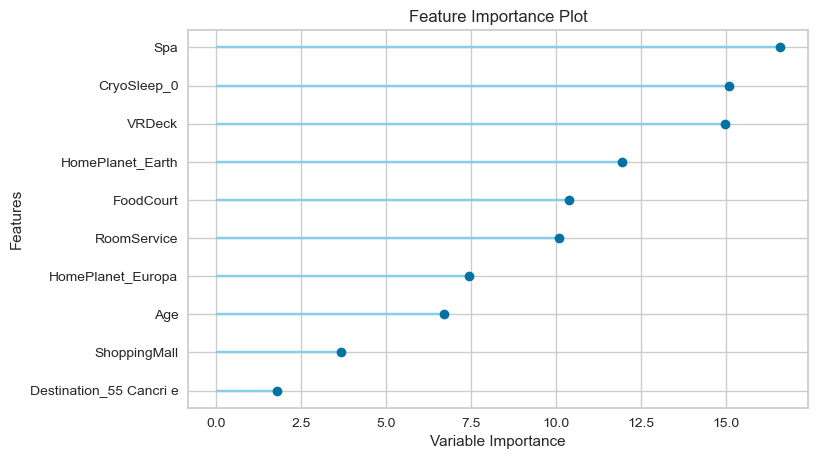

In [21]:
plot_model(catboost, plot='feature')

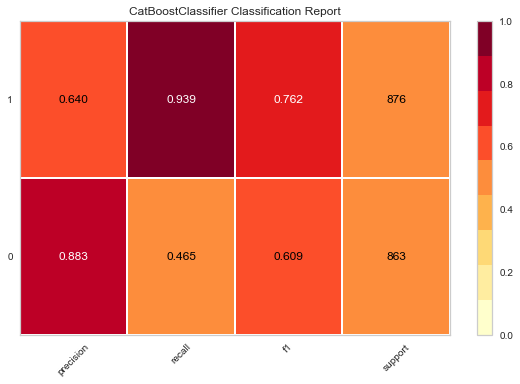

In [22]:
plot_model(catboost, plot="class_report")

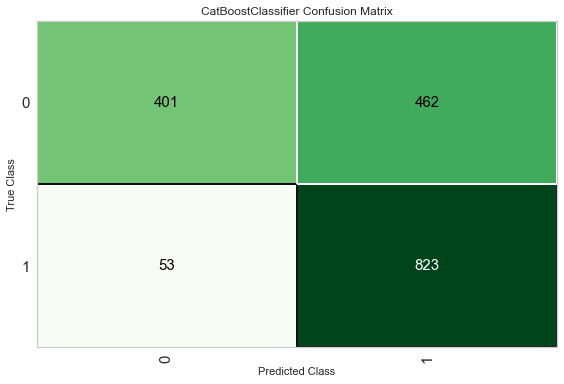

In [23]:
plot_model(catboost, plot = 'confusion_matrix')
#model is not so good predicting the not transported

In [24]:
#prediction on the validation dataset 

predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7039,0.8553,0.9395,0.6405,0.7617,0.4056,0.4601


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_0,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported,Label,Score
0,1.000000,0.0,0.000000,60.391304,23.012049,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,0.6751
1,0.944444,0.0,7.247787,18.152174,3.204819,57.126762,0.0,1.0,0.0,0.0,0.0,0.0,1.0,False,False,0.7283
2,0.444444,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True,True,0.9603
3,-0.277778,0.0,0.000000,7.217391,5.325301,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,0.5410
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,True,True,0.9351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,True,True,0.8796
1735,-0.055556,0.0,0.000000,17.978260,0.012048,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,False,True,0.7348
1736,0.055556,11.8,0.000000,0.000000,0.000000,1.056338,1.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,0.6202
1737,0.277778,0.0,0.000000,3.883020,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,True,True,0.6715


In [25]:
final= finalize_model(catboost)

In [26]:
#unseen data (test)

df2 = pd.read_csv('test2.csv')
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [27]:
#Working on the test dataset the same way we worked on the train dataset

x_cluster2 = df2.loc[:, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
x_cluster_new2 = imputer.transform(x_cluster2)
df2['Cluster']= model_kmeans.fit_predict(x_cluster_new2)
df2['Cluster'] = df2['Cluster'].astype("category")
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cluster
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,2
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1


In [28]:
df2['Age'] = df2['Age'].fillna(df.groupby('HomePlanet')['Age'].transform('median'))
df['CryoSleep'] = df['CryoSleep'].fillna(df.groupby('Cluster')['CryoSleep'].transform('mean'))
df2.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age               4
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Cluster           0
dtype: int64

In [31]:
#final predicition and create submission file 

df_pred = predict_model(final, data=df2)
df_sub = df_pred.loc[:, ['PassengerId', 'Label']].rename(columns = {'Label':'Transported'})
df_sub.to_csv('submission.csv', index = False)

In [ ]:
#score de 0.79448 usando media de idade considerando os planetas de origem e fill na em cryosleep, considerando os clusters